#### This notebook is post-processing curvature points to extract the approximate location of the corners.

In [1]:
import pandas as pd

In [2]:
points = pd.read_csv("/Users/valentina/projects/cornea_project/Lepto/processed/thesholded_curvature.csv")

In [3]:
import matplotlib.pyplot as plt
%matplotlib notebook

In [4]:
points.Gauss_Curvature.max()
points_subset = points[points['Gauss_Curvature'].between(0.04,0.05)]
points_subset.shape

(1916, 7)

In [5]:
from sklearn.cluster import KMeans
import numpy as np
X = points_subset[["Points:0","Points:1","Points:2"]]
kmeans = KMeans(n_clusters = 200,random_state=0).fit(X)
#kmeans.labels_
kmeans.labels_

array([ 56, 164,  56, ...,  30,  30, 110], dtype=int32)

<IPython.core.display.Javascript object>


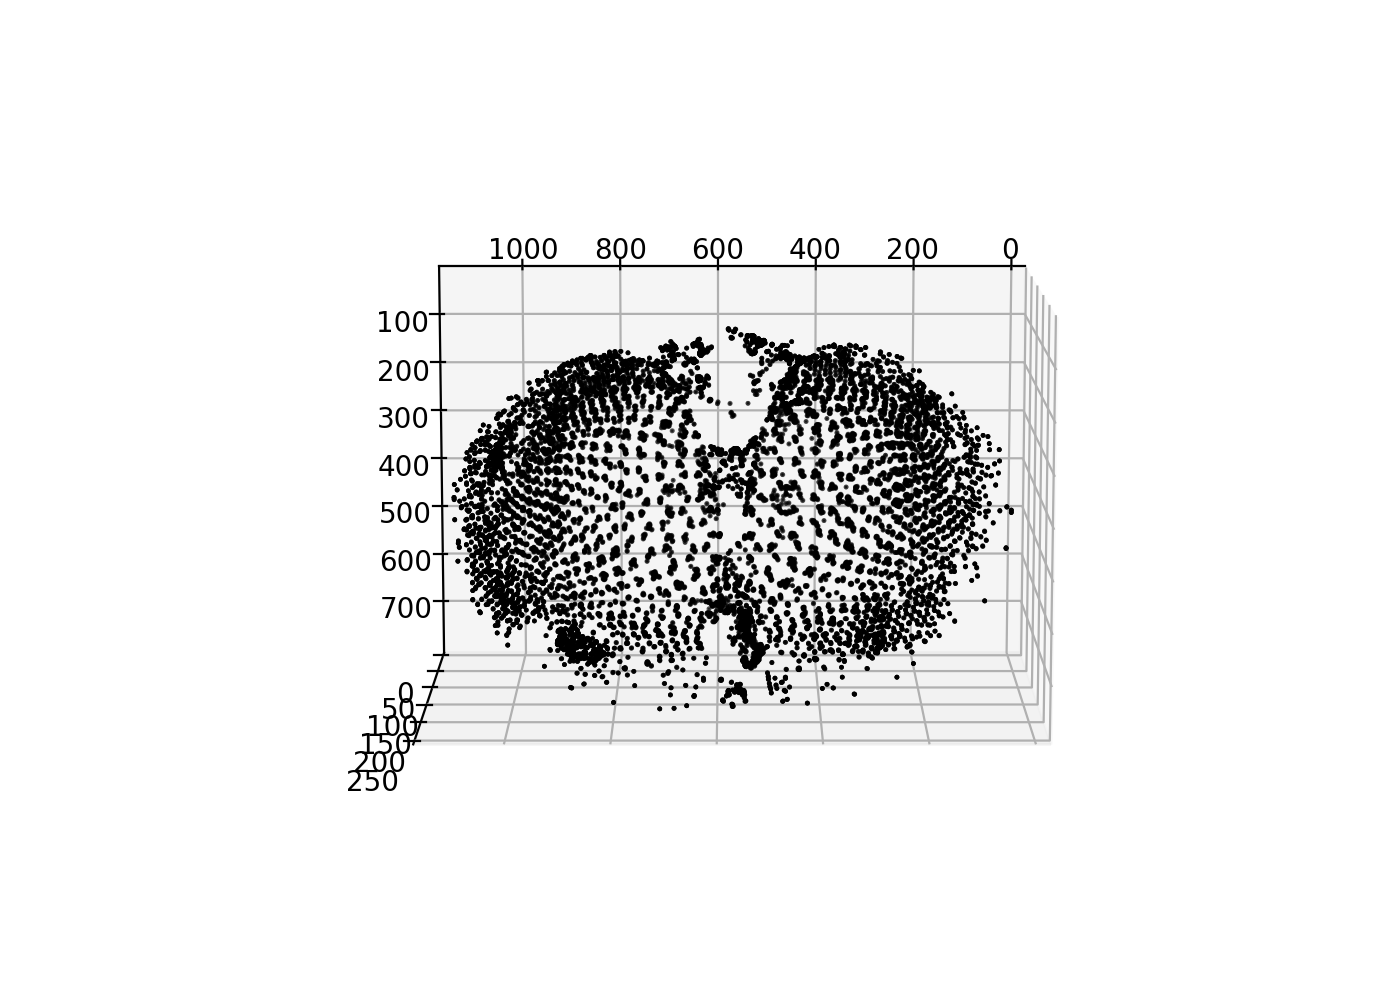

In [6]:
# plot the centers
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize = (7,5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points["Points:0"], points["Points:1"],points["Points:2"], color='black', s=0.5, cmap='viridis')
plt.autoscale(enable=True, axis='both',tight=True)
ax.set_aspect('equal','box')
ax.view_init(100, 90)
plt.draw()

In [14]:
kmeans.cluster_centers_

array([[  442.87625   ,   137.165     ,   135.835     ],
       [  808.42857143,   655.94428571,   122.82857143],
       [  302.41666667,   503.41666667,    65.44766667],
       [  922.76923077,   365.53846154,    67.55953846],
       [  551.12214286,   609.94214286,    92.34142857],
       [  625.09090909,   394.81818182,    39.55381818],
       [  327.33333333,   301.16666667,    44.02516667],
       [  715.88888889,   144.96666667,   129.56777778],
       [ 1020.10833333,   563.29083333,   213.85      ],
       [  279.40230769,   662.34538462,   189.20615385],
       [  983.783     ,   221.329     ,   218.086     ],
       [  477.75      ,   474.58333333,    35.951     ],
       [  158.2       ,   379.7       ,   108.3818    ],
       [  802.14285714,   524.14285714,    51.81128571],
       [  880.61538462,   642.46692308,   188.36230769],
       [  548.29764706,   688.70823529,    96.18138235],
       [  526.8       ,   298.79285714,   120.96428571],
       [  791.45454545,   319.0

<IPython.core.display.Javascript object>


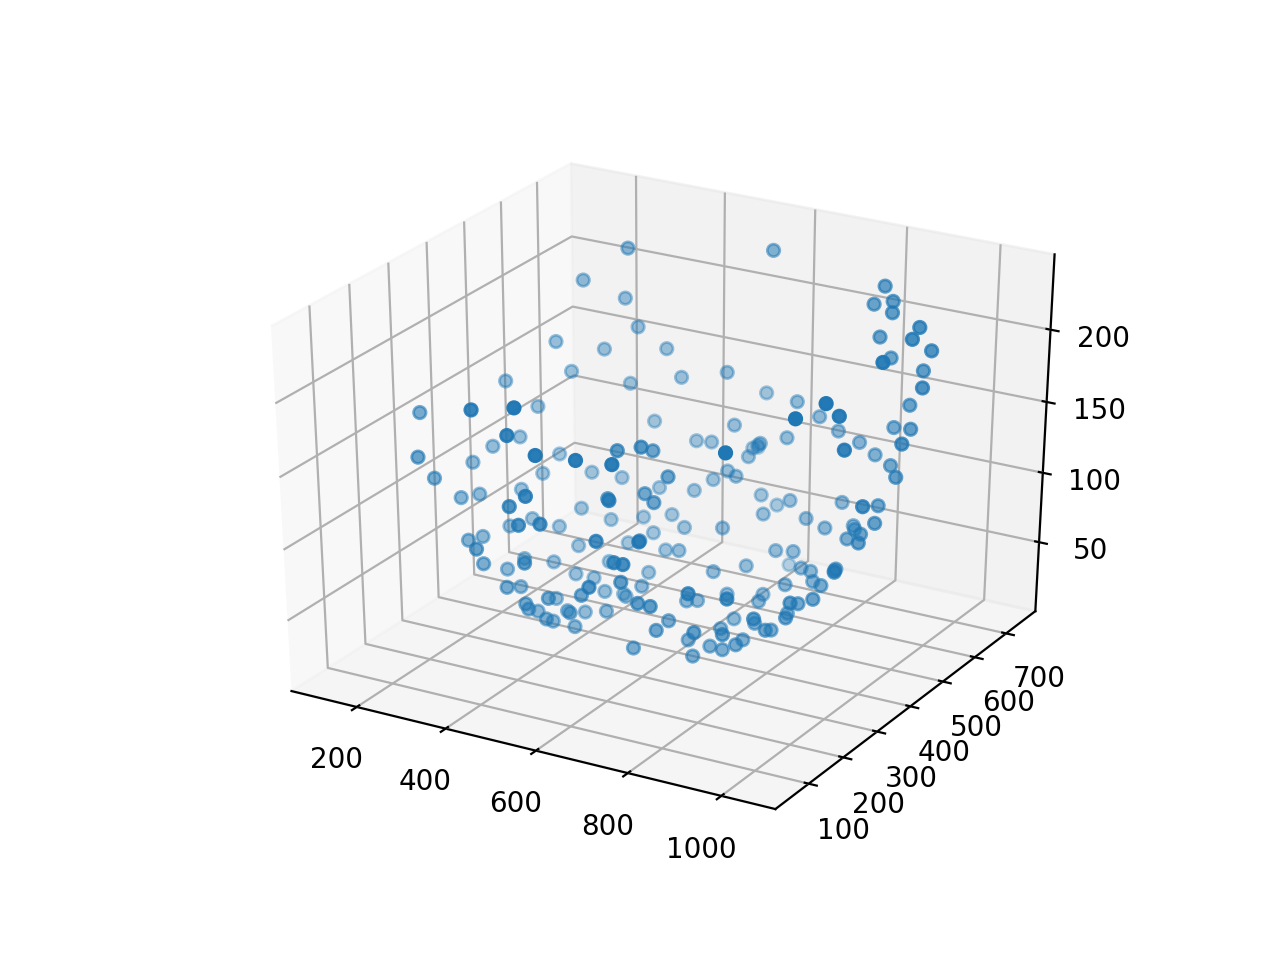

In [8]:
# plot the centers
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1], kmeans.cluster_centers_[:,2])

In [15]:
from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(X)
distances, indices = nbrs.kneighbors(X)

In [16]:
G = nbrs.kneighbors_graph(X, mode='distance').toarray()

In [17]:
G.shape

(1916, 1916)

In [18]:
from sklearn import cluster
spectral = cluster.SpectralClustering(
    n_clusters=20, eigen_solver='arpack',
    affinity="nearest_neighbors")

In [19]:
spectral.fit(X)

/Users/valentina/anaconda/lib/python3.6/site-packages/sklearn/manifold/spectral_embedding_.py:229: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


SpectralClustering(affinity='nearest_neighbors', assign_labels='kmeans',
          coef0=1, degree=3, eigen_solver='arpack', eigen_tol=0.0,
          gamma=1.0, kernel_params=None, n_clusters=20, n_init=10,
          n_jobs=1, n_neighbors=10, random_state=None)

In [20]:
from itertools import cycle, islice
spectral.labels_
y_pred = spectral.labels_.astype(np.int)
# colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
#                                             '#f781bf', '#a65628', '#984ea3',
#                                             '#999999', '#e41a1c', '#dede00']),
#                                      int(max(y_pred) + 1))))
fig = plt.figure(figsize = (7,5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points_subset["Points:0"], points_subset["Points:1"],points_subset["Points:2"], s=1, color=spectral.labels_)
ax.view_init(100, 90)
plt.show()

<IPython.core.display.Javascript object>

ValueError: 'color' kwarg must be an mpl color spec or sequence of color specs.
For a sequence of values to be color-mapped, use the 'c' kwarg instead.

#### Visualization with Plotly

In [171]:
import plotly.plotly as py
import plotly.graph_objs as go
from plotly import tools

In [322]:
labels = spectral.labels_
trace = go.Scatter3d(x=points_subset["Points:1"], y=points_subset["Points:0"],z=points_subset["Points:2"],
                         showlegend=False,
                         mode='markers',
                         marker=dict(
                                size=1,
                                color=labels.astype(np.float),
                                line=dict(color='black', width=1)))

In [323]:
fig = tools.make_subplots(rows=1, cols=1,
                          print_grid=False,
                          specs=[[{'is_3d': True}]])

In [342]:
scene = dict(
    aspectmode = 'data',
    camera = dict(
    up=dict(x=0, y=1, z=1),
    center=dict(x=0, y=0, z=0),
    eye=dict(x=2.5, y=0.5, z=2.5)
    ),
    xaxis=dict(
        range=[0, 1000],
        title='x',
        gridcolor='rgb(255, 255, 255)',
        zerolinecolor='rgb(255, 255, 255)',
        showbackground=True,
        backgroundcolor='rgb(230, 230,230)',
        showticklabels=False, ticks=''
    ),
    yaxis=dict(
        range=[0, 1000],
        title='y',
        gridcolor='rgb(255, 255, 255)',
        zerolinecolor='rgb(255, 255, 255)',
        showbackground=True,
        backgroundcolor='rgb(230, 230,230)',
        showticklabels=False, ticks=''
    ),
    zaxis=dict(
        range=[1,200],
        title='z',
        gridcolor='rgb(255, 255, 255)',
        zerolinecolor='rgb(255, 255, 255)',
        showbackground=True,
        backgroundcolor='rgb(230, 230,230)',
        showticklabels=False, ticks=''
    )
)

In [343]:
#fig = go.Figure(data=data, layout=layout)

fig.append_trace(trace,1,1)



fig['layout']['scene1'].update(scene)
#fig['layout']['scene2'].update(scene)
#fig['layout']['scene3'].update(scene)
#fig['layout']['scene4'].update(scene)
#fig['layout']['scene5'].update(scene)

In [344]:
py.iplot(fig,filename='clustering')